In [1]:
import os
os.chdir("/home/jupyter/Natasha2")# for GCP use
#os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from numpy import *
import inspect
import time
import torch
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Lambda
from torch.utils.data import DataLoader
from Natasha1 import Natasha1
from Natasha2 import Natasha2
from utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MNIST

In [2]:
from train import train_val_Mnist

learning curves have the following information:  
train_loss  
validation_loss  
precision  
recall  
F1  
accuracy  

## LeNet

In [3]:
learning_curves_Natasha1_LeNet = train_val_Mnist(algorithm='Natasha1', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm Natasha1
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.20483447417521528, validation loss: 2.301137685775757
	     precision: 0.0098
	        recall: 0.0994
	            F1: 0.0178
	      accuracy: 0.0983



Epoch 2/10, training loss: 0.21460897226069273, validation loss: 2.1910858154296875
	     precision: 0.0236
	        recall: 0.1060
	            F1: 0.0360
	      accuracy: 0.1029



Epoch 3/10, training loss: 0.18499587161708742, validation loss: 1.9553308486938477
	     precision: 0.1397
	        recall: 0.2241
	            F1: 0.1474
	      accuracy: 0.2359



Epoch 4/10, training loss: 0.17660426305555332, validation loss: 1.5488508939743042
	     precision: 0.3008
	        recall: 0.4266
	            F1: 0.3302
	      accuracy: 0.4403



Epoch 5/10, training loss: 0.13509597618188432, validation loss: 1.3824816942214966
	     precision: 0.3657
	        recall: 0.4837
	            F1: 0.3835
	      accuracy: 0.4977



Epoch 6/10, training loss: 0.11270074549514347, validation loss: 1.3300511837005615
	     precision: 0.3686
	        recall: 0.4885
	            F1: 0.3863
	      accuracy: 0.5021



Epoch 7/10, training loss: 0.1356179493068378, validation loss: 1.2594019174575806
	     precision: 0.4280
	        recall: 0.4911
	            F1: 0.4179
	      accuracy: 0.5033



Epoch 8/10, training loss: 0.10752389883435866, validation loss: 1.2129014730453491
	     precision: 0.4576
	        recall: 0.5142
	            F1: 0.4390
	      accuracy: 0.5303



Epoch 9/10, training loss: 0.11491790839603969, validation loss: 1.1029671430587769
	     precision: 0.5079
	        recall: 0.5622
	            F1: 0.4877
	      accuracy: 0.5770



Epoch 10/10, training loss: 0.1008307419097754, validation loss: 0.9051276445388794
	     precision: 0.6137
	        recall: 0.6127
	            F1: 0.5537
	      accuracy: 0.6223
Training time: 88.40814280509949s


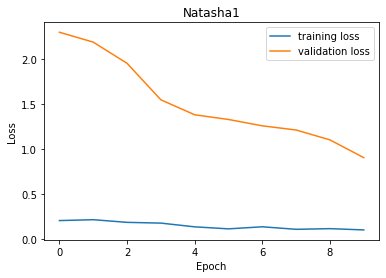

In [4]:
ax = plt.axes()
ax.set_title("Natasha1")
ax.plot(learning_curves_Natasha1_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_Natasha1_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [5]:
learning_curves_Adam_LeNet = train_val_Mnist(algorithm='Adam', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm Adam
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.23304440306702148, validation loss: 1.9305298328399658
	     precision: 0.2569
	        recall: 0.3702
	            F1: 0.2512
	      accuracy: 0.3797



Epoch 2/10, training loss: 0.17132666586304524, validation loss: 1.1457233428955078
	     precision: 0.6672
	        recall: 0.6549
	            F1: 0.6182
	      accuracy: 0.6598



Epoch 3/10, training loss: 0.09465799351999246, validation loss: 0.8972457647323608
	     precision: 0.7453
	        recall: 0.7358
	            F1: 0.7155
	      accuracy: 0.7428



Epoch 4/10, training loss: 0.0941777696360403, validation loss: 0.7468284964561462
	     precision: 0.7837
	        recall: 0.7743
	            F1: 0.7561
	      accuracy: 0.7822



Epoch 5/10, training loss: 0.0749132520417923, validation loss: 0.6701325178146362
	     precision: 0.8089
	        recall: 0.8033
	            F1: 0.7875
	      accuracy: 0.8093



Epoch 6/10, training loss: 0.06207669998155728, validation loss: 0.6157877445220947
	     precision: 0.8279
	        recall: 0.8212
	            F1: 0.8093
	      accuracy: 0.8272



Epoch 7/10, training loss: 0.07032289986671415, validation loss: 0.5815802812576294
	     precision: 0.8403
	        recall: 0.8285
	            F1: 0.8183
	      accuracy: 0.8347



Epoch 8/10, training loss: 0.05422796537754124, validation loss: 0.5471628308296204
	     precision: 0.8461
	        recall: 0.8380
	            F1: 0.8275
	      accuracy: 0.8435



Epoch 9/10, training loss: 0.05706994794706292, validation loss: 0.537442684173584
	     precision: 0.8505
	        recall: 0.8431
	            F1: 0.8323
	      accuracy: 0.8478



Epoch 10/10, training loss: 0.04975915646184482, validation loss: 0.5197106003761292
	     precision: 0.8584
	        recall: 0.8488
	            F1: 0.8388
	      accuracy: 0.8536
Training time: 73.51675748825073s


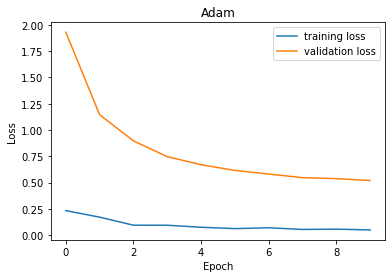

In [6]:
ax = plt.axes()
ax.set_title("Adam")
ax.plot(learning_curves_Adam_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_Adam_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [7]:
learning_curves_SGD_LeNet = train_val_Mnist(algorithm='SGD', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm SGD
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.21535358423871526, validation loss: 2.3144397735595703
	     precision: 0.0103
	        recall: 0.0994
	            F1: 0.0185
	      accuracy: 0.1026



Epoch 2/10, training loss: 0.23744360190718922, validation loss: 2.27447509765625
	     precision: 0.0103
	        recall: 0.0994
	            F1: 0.0185
	      accuracy: 0.1026



Epoch 3/10, training loss: 0.2392151114274698, validation loss: 2.142587900161743
	     precision: 0.0946
	        recall: 0.1664
	            F1: 0.0888
	      accuracy: 0.1683



Epoch 4/10, training loss: 0.24051875702099507, validation loss: 1.8507452011108398
	     precision: 0.2048
	        recall: 0.3546
	            F1: 0.2352
	      accuracy: 0.3583



Epoch 5/10, training loss: 0.1932037885763498, validation loss: 1.6711071729660034
	     precision: 0.2744
	        recall: 0.4252
	            F1: 0.3093
	      accuracy: 0.4288



Epoch 6/10, training loss: 0.1543483082165342, validation loss: 1.5871127843856812
	     precision: 0.2901
	        recall: 0.4393
	            F1: 0.3242
	      accuracy: 0.4428



Epoch 7/10, training loss: 0.15653775978698406, validation loss: 1.517812967300415
	     precision: 0.3072
	        recall: 0.4426
	            F1: 0.3296
	      accuracy: 0.4458



Epoch 8/10, training loss: 0.18129196006860307, validation loss: 1.4578064680099487
	     precision: 0.3513
	        recall: 0.4563
	            F1: 0.3548
	      accuracy: 0.4580



Epoch 9/10, training loss: 0.15512624872264577, validation loss: 1.4480957984924316
	     precision: 0.3544
	        recall: 0.4466
	            F1: 0.3485
	      accuracy: 0.4475



Epoch 10/10, training loss: 0.15960254648855246, validation loss: 1.4017720222473145
	     precision: 0.3607
	        recall: 0.4586
	            F1: 0.3637
	      accuracy: 0.4617
Training time: 72.8237099647522s


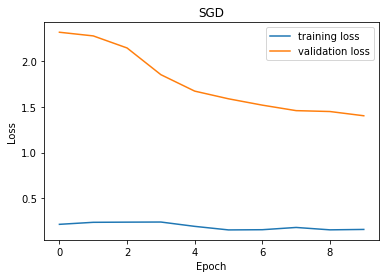

In [8]:
ax = plt.axes()
ax.set_title("SGD")
ax.plot(learning_curves_SGD_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [9]:
learning_curves_SGD_momentum_LeNet = train_val_Mnist(algorithm='SGD_momentum', cuda=0, epochs=10, train_portion=0.1, model='MnistLeNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm SGD_momentum
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.21314877258943343, validation loss: 2.0310542583465576
	     precision: 0.1140
	        recall: 0.2112
	            F1: 0.1215
	      accuracy: 0.2188



Epoch 2/10, training loss: 0.15206733631935201, validation loss: 1.094724178314209
	     precision: 0.5151
	        recall: 0.5636
	            F1: 0.5049
	      accuracy: 0.5759



Epoch 3/10, training loss: 0.09976193251640303, validation loss: 0.9169657826423645
	     precision: 0.6866
	        recall: 0.6920
	            F1: 0.6581
	      accuracy: 0.7026



Epoch 4/10, training loss: 0.08396138794132388, validation loss: 0.6339449882507324
	     precision: 0.8099
	        recall: 0.7926
	            F1: 0.7751
	      accuracy: 0.7972



Epoch 5/10, training loss: 0.04369189852336322, validation loss: 0.5920023918151855
	     precision: 0.8426
	        recall: 0.8253
	            F1: 0.8114
	      accuracy: 0.8264



Epoch 6/10, training loss: 0.06366021769133204, validation loss: 0.4961548447608948
	     precision: 0.8576
	        recall: 0.8427
	            F1: 0.8308
	      accuracy: 0.8453



Epoch 7/10, training loss: 0.050615119432081294, validation loss: 0.38691437244415283
	     precision: 0.8905
	        recall: 0.8818
	            F1: 0.8733
	      accuracy: 0.8854



Epoch 8/10, training loss: 0.04453275565590177, validation loss: 0.35958462953567505
	     precision: 0.8928
	        recall: 0.8876
	            F1: 0.8766
	      accuracy: 0.8895



Epoch 9/10, training loss: 0.043912989879722024, validation loss: 0.3650698959827423
	     precision: 0.9066
	        recall: 0.8902
	            F1: 0.8841
	      accuracy: 0.8902



Epoch 10/10, training loss: 0.03721636408236998, validation loss: 0.29858213663101196
	     precision: 0.9131
	        recall: 0.9063
	            F1: 0.8989
	      accuracy: 0.9075
Training time: 73.06271481513977s


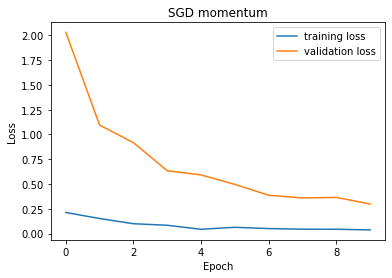

In [10]:
ax = plt.axes()
ax.set_title("SGD momentum")
ax.plot(learning_curves_SGD_momentum_LeNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_momentum_LeNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

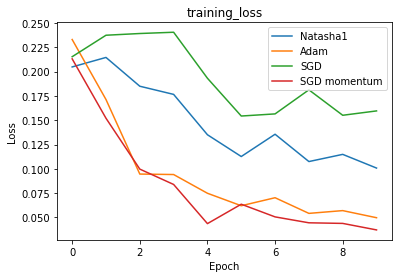

In [11]:
ax = plt.axes()
ax.set_title("training_loss")
ax.plot(learning_curves_Natasha1_LeNet['train_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_LeNet['train_loss'], label='Adam')
ax.plot(learning_curves_SGD_LeNet['train_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_LeNet['train_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

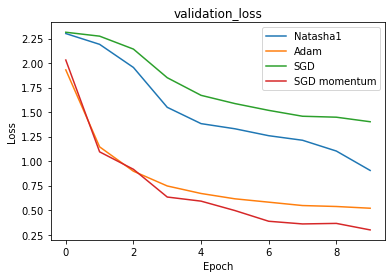

In [12]:
ax = plt.axes()
ax.set_title("validation_loss")
ax.plot(learning_curves_Natasha1_LeNet['validation_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_LeNet['validation_loss'], label='Adam')
ax.plot(learning_curves_SGD_LeNet['validation_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_LeNet['validation_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

## ResNet

In [13]:
learning_curves_Natasha1_ResNet = train_val_Mnist(algorithm='Natasha1', cuda=0, epochs=10, train_portion=0.1, model='MnistResNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm Natasha1
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.03506034637676246, validation loss: 0.14694347977638245
	     precision: 0.9535
	        recall: 0.9533
	            F1: 0.9484
	      accuracy: 0.9541



Epoch 2/10, training loss: 0.013068062509459728, validation loss: 0.1225949078798294
	     precision: 0.9625
	        recall: 0.9603
	            F1: 0.9566
	      accuracy: 0.9624



Epoch 3/10, training loss: 0.011480304176238045, validation loss: 0.09147273749113083
	     precision: 0.9694
	        recall: 0.9688
	            F1: 0.9657
	      accuracy: 0.9705



Epoch 4/10, training loss: 0.008891716261884805, validation loss: 0.07441984117031097
	     precision: 0.9758
	        recall: 0.9750
	            F1: 0.9728
	      accuracy: 0.9766



Epoch 5/10, training loss: 0.006726316885272069, validation loss: 0.05464106798171997
	     precision: 0.9832
	        recall: 0.9827
	            F1: 0.9813
	      accuracy: 0.9828



Epoch 6/10, training loss: 0.00687473100512775, validation loss: 0.05867931246757507
	     precision: 0.9813
	        recall: 0.9798
	            F1: 0.9786
	      accuracy: 0.9813



Epoch 7/10, training loss: 0.006911050663319732, validation loss: 0.04970719292759895
	     precision: 0.9824
	        recall: 0.9823
	            F1: 0.9807
	      accuracy: 0.9831



Epoch 8/10, training loss: 0.005701112832977319, validation loss: 0.04828154668211937
	     precision: 0.9857
	        recall: 0.9848
	            F1: 0.9836
	      accuracy: 0.9855



Epoch 9/10, training loss: 0.005286498154118371, validation loss: 0.04876390099525452
	     precision: 0.9849
	        recall: 0.9844
	            F1: 0.9830
	      accuracy: 0.9851



Epoch 10/10, training loss: 0.004284832473677486, validation loss: 0.06172261759638786
	     precision: 0.9804
	        recall: 0.9803
	            F1: 0.9783
	      accuracy: 0.9808
Training time: 217.4155662059784s


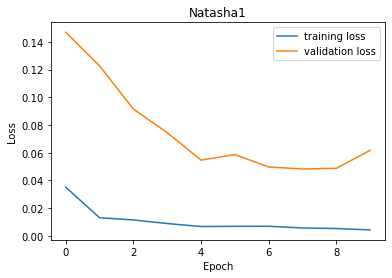

In [14]:
ax = plt.axes()
ax.set_title("Natasha1")
ax.plot(learning_curves_Natasha1_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_Natasha1_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [18]:
learning_curves_Adam_ResNet = train_val_Mnist(algorithm='Adam', cuda=0, epochs=10, train_portion=0.1, model='MnistResNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm Adam
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.033678192351418515, validation loss: 0.20837444067001343
	     precision: 0.9389
	        recall: 0.9291
	            F1: 0.9242
	      accuracy: 0.9321



Epoch 2/10, training loss: 0.01685938990112942, validation loss: 0.11176598072052002
	     precision: 0.9700
	        recall: 0.9665
	            F1: 0.9646
	      accuracy: 0.9681



Epoch 3/10, training loss: 0.013421705759156233, validation loss: 0.23018352687358856
	     precision: 0.9416
	        recall: 0.9305
	            F1: 0.9255
	      accuracy: 0.9322



Epoch 4/10, training loss: 0.013821833006449853, validation loss: 0.09485972672700882
	     precision: 0.9734
	        recall: 0.9709
	            F1: 0.9693
	      accuracy: 0.9724



Epoch 5/10, training loss: 0.009311521306697493, validation loss: 0.09353845566511154
	     precision: 0.9729
	        recall: 0.9706
	            F1: 0.9686
	      accuracy: 0.9719



Epoch 6/10, training loss: 0.010443284358980178, validation loss: 0.05829208716750145
	     precision: 0.9813
	        recall: 0.9809
	            F1: 0.9794
	      accuracy: 0.9812



Epoch 7/10, training loss: 0.0075168214094981966, validation loss: 0.12312497943639755
	     precision: 0.9670
	        recall: 0.9623
	            F1: 0.9590
	      accuracy: 0.9620



Epoch 8/10, training loss: 0.005528200096063522, validation loss: 0.06302709132432938
	     precision: 0.9805
	        recall: 0.9806
	            F1: 0.9785
	      accuracy: 0.9803



Epoch 9/10, training loss: 0.006115579514948925, validation loss: 0.08111616969108582
	     precision: 0.9770
	        recall: 0.9756
	            F1: 0.9737
	      accuracy: 0.9760



Epoch 10/10, training loss: 0.007819294780572214, validation loss: 0.05198507383465767
	     precision: 0.9840
	        recall: 0.9835
	            F1: 0.9820
	      accuracy: 0.9836
Training time: 98.14243674278259s


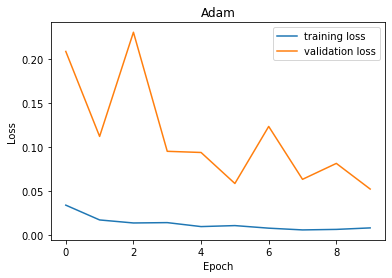

In [19]:
ax = plt.axes()
ax.set_title("Adam")
ax.plot(learning_curves_Adam_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_Adam_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [20]:
learning_curves_SGD_ResNet = train_val_Mnist(algorithm='SGD', cuda=0, epochs=10, train_portion=0.1, model='MnistResNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm SGD
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.05958172928359209, validation loss: 0.22719796001911163
	     precision: 0.9374
	        recall: 0.9347
	            F1: 0.9289
	      accuracy: 0.9354



Epoch 2/10, training loss: 0.016850840355922925, validation loss: 0.13916681706905365
	     precision: 0.9585
	        recall: 0.9586
	            F1: 0.9544
	      accuracy: 0.9588



Epoch 3/10, training loss: 0.01534487287611214, validation loss: 0.10895437747240067
	     precision: 0.9664
	        recall: 0.9656
	            F1: 0.9625
	      accuracy: 0.9671



Epoch 4/10, training loss: 0.012514223255264734, validation loss: 0.08935849368572235
	     precision: 0.9716
	        recall: 0.9724
	            F1: 0.9689
	      accuracy: 0.9721



Epoch 5/10, training loss: 0.009588135465947804, validation loss: 0.07470983266830444
	     precision: 0.9771
	        recall: 0.9771
	            F1: 0.9750
	      accuracy: 0.9770



Epoch 6/10, training loss: 0.007048676648278481, validation loss: 0.07275163382291794
	     precision: 0.9767
	        recall: 0.9765
	            F1: 0.9745
	      accuracy: 0.9771



Epoch 7/10, training loss: 0.007581134217539067, validation loss: 0.06414967775344849
	     precision: 0.9801
	        recall: 0.9788
	            F1: 0.9774
	      accuracy: 0.9796



Epoch 8/10, training loss: 0.006792886738679302, validation loss: 0.057797834277153015
	     precision: 0.9817
	        recall: 0.9814
	            F1: 0.9796
	      accuracy: 0.9817



Epoch 9/10, training loss: 0.005777097742027565, validation loss: 0.05584233999252319
	     precision: 0.9838
	        recall: 0.9839
	            F1: 0.9824
	      accuracy: 0.9839



Epoch 10/10, training loss: 0.006354279830051002, validation loss: 0.05424867570400238
	     precision: 0.9827
	        recall: 0.9832
	            F1: 0.9813
	      accuracy: 0.9830
Training time: 94.52169680595398s


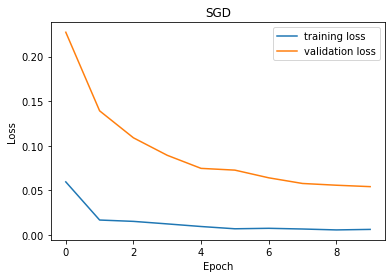

In [21]:
ax = plt.axes()
ax.set_title("SGD")
ax.plot(learning_curves_SGD_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

In [22]:
learning_curves_SGD_momentum_ResNet = train_val_Mnist(algorithm='SGD_momentum', cuda=0, epochs=10, train_portion=0.1, model='MnistResNet')

[train.py] Using cuda device 0
[train.py] using optimization algorithm SGD_momentum
[train.pu] training with 10% of data



Epoch 1/10, training loss: 0.047832379614048674, validation loss: 0.36886066198349
	     precision: 0.9204
	        recall: 0.9052
	            F1: 0.8961
	      accuracy: 0.9063



Epoch 2/10, training loss: 0.01585796100101364, validation loss: 0.07390095293521881
	     precision: 0.9771
	        recall: 0.9772
	            F1: 0.9748
	      accuracy: 0.9778



Epoch 3/10, training loss: 0.009325991321140642, validation loss: 0.08105119317770004
	     precision: 0.9758
	        recall: 0.9736
	            F1: 0.9719
	      accuracy: 0.9741



Epoch 4/10, training loss: 0.010678989659828036, validation loss: 0.05693783983588219
	     precision: 0.9837
	        recall: 0.9826
	            F1: 0.9814
	      accuracy: 0.9833



Epoch 5/10, training loss: 0.006083370486238618, validation loss: 0.054515354335308075
	     precision: 0.9836
	        recall: 0.9830
	            F1: 0.9814
	      accuracy: 0.9833



Epoch 6/10, training loss: 0.00806418993174712, validation loss: 0.04934709519147873
	     precision: 0.9850
	        recall: 0.9850
	            F1: 0.9835
	      accuracy: 0.9856



Epoch 7/10, training loss: 0.006194376202026156, validation loss: 0.049341876059770584
	     precision: 0.9850
	        recall: 0.9846
	            F1: 0.9833
	      accuracy: 0.9853



Epoch 8/10, training loss: 0.005524135772575702, validation loss: 0.047636471688747406
	     precision: 0.9856
	        recall: 0.9850
	            F1: 0.9836
	      accuracy: 0.9853



Epoch 9/10, training loss: 0.005056931031569997, validation loss: 0.05515887588262558
	     precision: 0.9831
	        recall: 0.9821
	            F1: 0.9806
	      accuracy: 0.9827



Epoch 10/10, training loss: 0.00599671296600594, validation loss: 0.05068877339363098
	     precision: 0.9848
	        recall: 0.9846
	            F1: 0.9829
	      accuracy: 0.9848
Training time: 97.08284950256348s


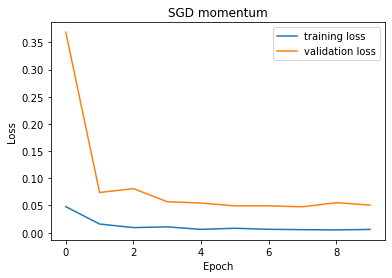

In [23]:
ax = plt.axes()
ax.set_title("SGD momentum")
ax.plot(learning_curves_SGD_momentum_ResNet['train_loss'], label='training loss')
ax.plot(learning_curves_SGD_momentum_ResNet['validation_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

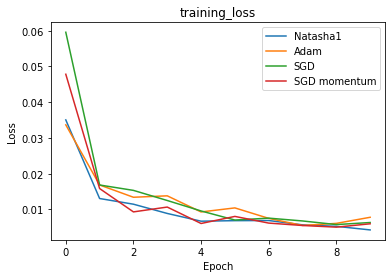

In [24]:
ax = plt.axes()
ax.set_title("training_loss")
ax.plot(learning_curves_Natasha1_ResNet['train_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_ResNet['train_loss'], label='Adam')
ax.plot(learning_curves_SGD_ResNet['train_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_ResNet['train_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

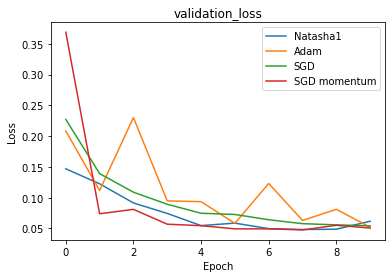

In [25]:
ax = plt.axes()
ax.set_title("validation_loss")
ax.plot(learning_curves_Natasha1_ResNet['validation_loss'], label='Natasha1')
ax.plot(learning_curves_Adam_ResNet['validation_loss'], label='Adam')
ax.plot(learning_curves_SGD_ResNet['validation_loss'], label='SGD')
ax.plot(learning_curves_SGD_momentum_ResNet['validation_loss'], label='SGD momentum')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()

# Linear model for debugging

In [ ]:
import numpy as np
# create dummy data for training
x_values = [i for i in range(11)]
x_train = np.array(x_values, dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_values = [2*i + 1 for i in x_values]
y_train = np.array(y_values, dtype=np.float32)
y_train = y_train.reshape(-1, 1)

In [ ]:
import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
inputDim = 1        # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 10

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

In [ ]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
optimizer = Natasha2(model.parameters(), alpha=learningRate)

In [ ]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda())
        labels = Variable(torch.from_numpy(y_train).cuda())
    else:
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward(retain_graph=True)
    
    hessian_matrix = eval_hessian(loss, model)
    # update parameters
    optimizer.step(hessian_matrix)

    print('epoch {}, loss {}'.format(epoch, loss.item()))